<a href="https://colab.research.google.com/github/kabume/Bast/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing SuPyMode and depedencies

In [16]:
# 2.1.0 pass 1
!python -m pip install SuPyMode==2.1.6 --no-cache-dir --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.9 MB/s eta 0:00:00


In [1]:
import SuPyMode
print(SuPyMode.__version__)

2.1.6


## Quick fix: restart the session after the !pip command above.
Go on Runtime/Restart Session

## Simplest case

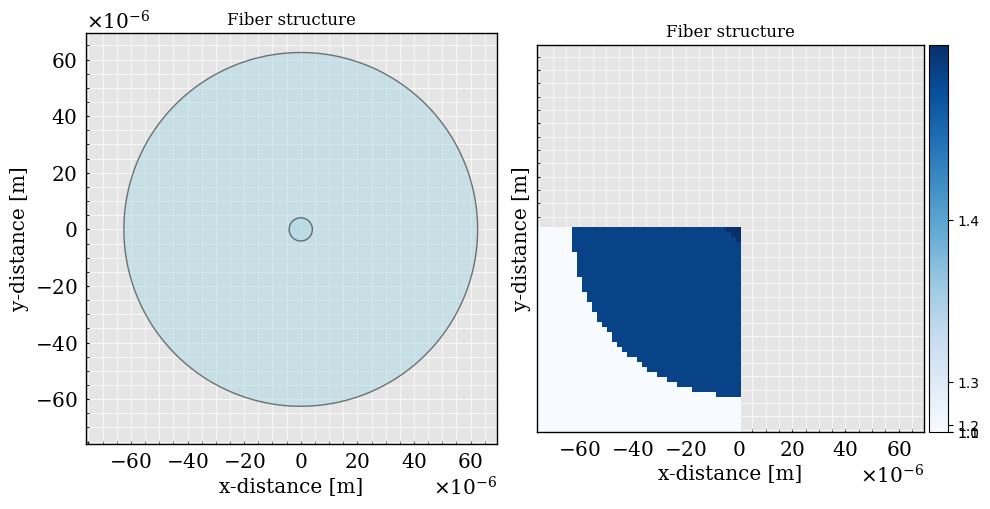

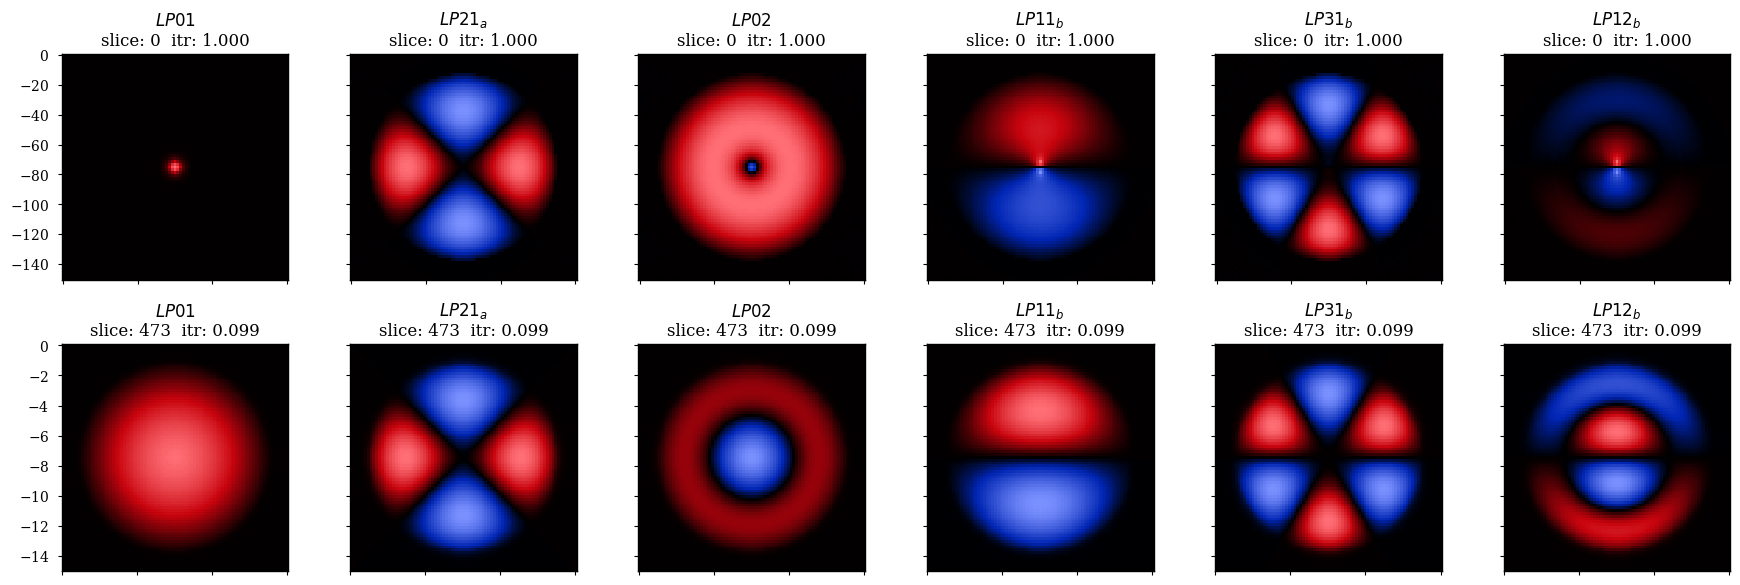

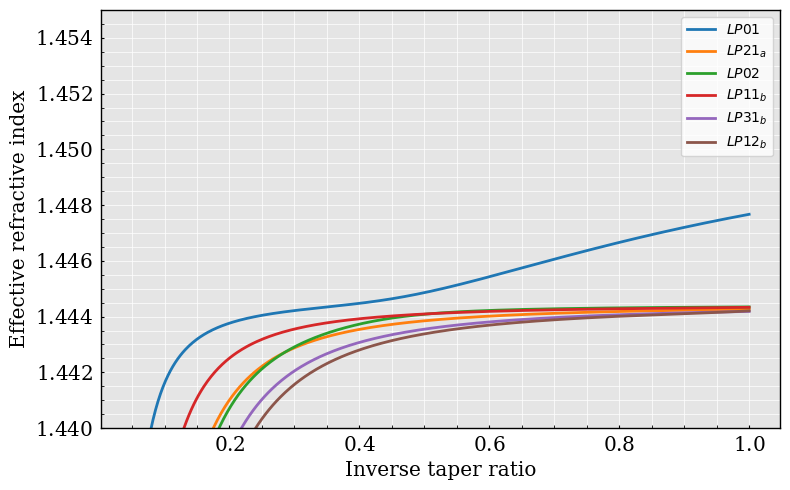

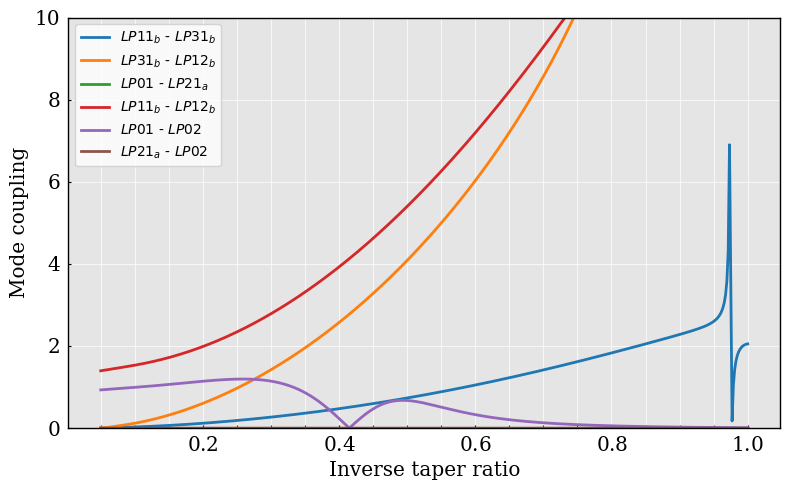

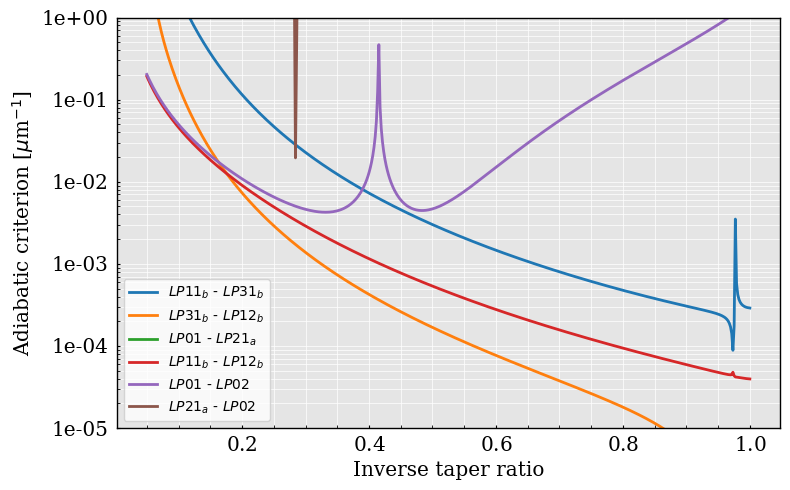

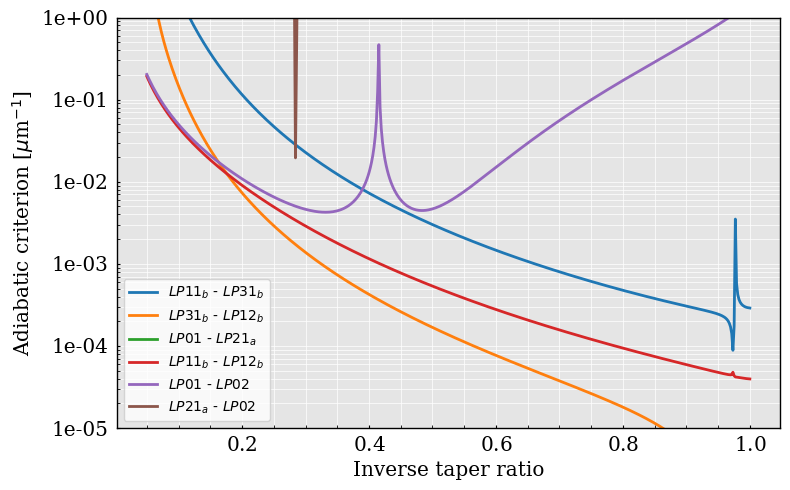

In [2]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment

wavelength = 1550e-9

fiber = fiber_loader.load_fiber('SMF28', clad_refractive_index=1.4444, remove_cladding=False)

boundaries = [
   Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.SYMMETRIC),
   Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.ANTI_SYMMETRIC)
]


workflow = Workflow(
   fiber_list=[fiber],             # List of fiber to be added in the mesh, the order matters.
   wavelength=wavelength,          # Wavelength used for the mode computation.
   resolution=80,                  # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
   x_bounds=DomainAlignment.LEFT,  # Mesh x-boundary structure.
   y_bounds=DomainAlignment.BOTTOM,# Mesh y-boundary structure.
   boundaries=boundaries,          # Set of symmetries to be evaluated, each symmetry add a round of simulation
   n_sorted_mode=3,                # Total computed and sorted mode.
   n_added_mode=2,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
   plot_geometry=True,             # Plot the geometry mesh before computation.
   auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
   itr_final=0.05,                 # Final value of inverse taper ratio to simulate
   index_scrambling=0              # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

workflow.superset.plot(plot_type='index')

workflow.superset.plot(plot_type='normalized-coupling')

workflow.superset.plot(plot_type='adiabatic')

## propagate demo

In [ ]:
# backup
from SuPyMode.workflow import Workflow, fiber_catalogue, configuration, Boundaries2D, AlphaProfile

clad_structure = configuration.ring.FusedProfile_02x02
fiber0 = fiber_catalogue.SMF28(wavelength=1.55e-6)
fiber1 = fiber_catalogue.SMF28(wavelength=1.55e-6)

workflow = Workflow(
    fiber_list=[fiber0,fiber1],
    clad_structure=clad_structure,
    fusion_degree=0.90,
    wavelength=1.55e-6,
    resolution=200,
    x_bounds="left-centering",
    y_bounds="top-centering",
    boundaries=[
        Boundaries2D(right="symmetric",bottom='symmetric'),
        Boundaries2D(right="anti-symmetric",bottom='symmetric')
    ],
    generate_report=False,
    debug_mode=True,
    n_sorted_mode=6
)

profile =AlphaProfile()

profile.add_taper_segment(
    alpha=0,
    initial_heating_length=5e-3,
    stretching_length=2e-3,
)

profile.initialize()

amplitudes, z, _ = superset.propagate(
    profile-profile,
    initial_amplitude=[1, 0, 0, 0, 0, 0],
    add_coupling = True,
    max_step = superset.wavelength / 400
)

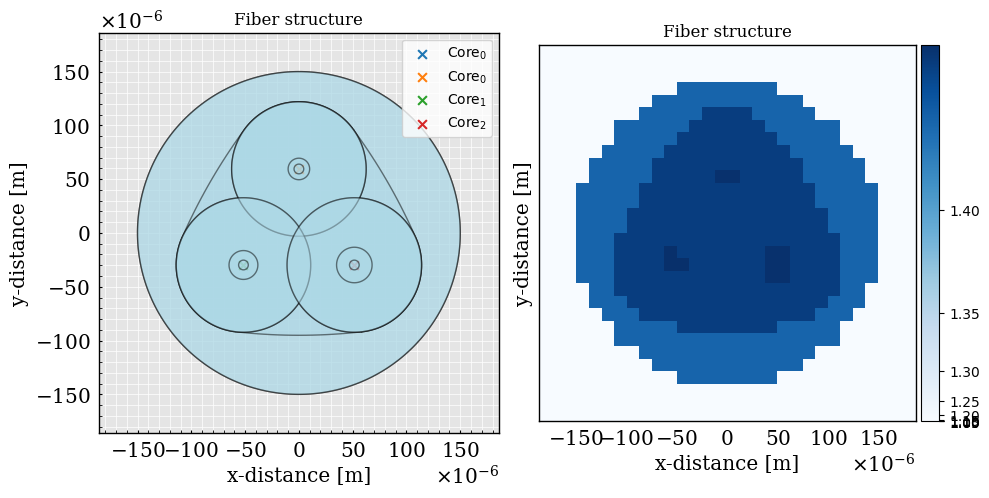

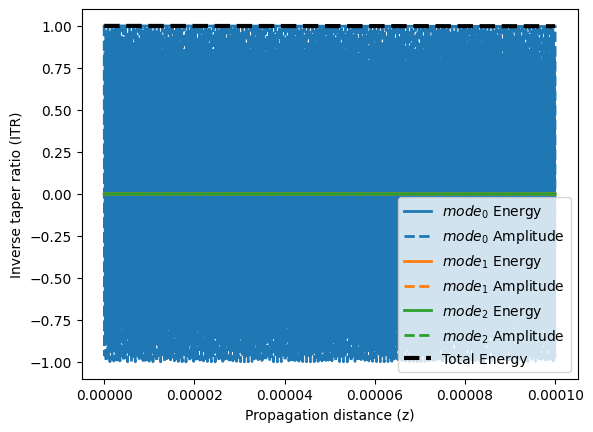

In [2]:
"""
plot_propagation.py
works in 2.1.6
4x4 Coupler [linear]
====================
"""

# %%
# Importing the script dependencies
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, DomainAlignment, Profile, StructureType
from SuPyMode.workflow import AlphaProfile

wavelength = 1550e-9

clad_refractive_index = 1.4444


# %%
# Generating the fiber structure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the cladding and fiber structure to model the problem
clad_structure = Profile()

clad_structure.add_structure(
    structure_type=StructureType.CIRCULAR,
    number_of_fibers=3,
    fusion_degree=0.3,
    fiber_radius=62.5e-6
)

clad_structure.refractive_index = clad_refractive_index


fiber_list = [
    fiber_loader.load_fiber('DCF1300S_20', clad_refractive_index=clad_refractive_index, position=clad_structure.cores[0]),
    fiber_loader.load_fiber('DCF1300S_26', clad_refractive_index=clad_refractive_index, position=clad_structure.cores[1]),
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_refractive_index, position=clad_structure.cores[2])
]

capillary_tube = Profile()

capillary_tube.add_center_fiber(
    fiber_radius=150e-6,
)

capillary_tube.refractive_index = clad_structure.refractive_index - 15e-3

# %%
# Generating the computing workflow
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Workflow class to define all the computation parameters before initializing the solver
workflow = Workflow(
    fiber_list=fiber_list,              # List of fiber to be added in the mesh, the order matters.
    clad_structure=clad_structure,      # Cladding structure, if None provided then no cladding is set.
    capillary_tube=capillary_tube,
    wavelength=wavelength,              # Wavelength used for the mode computation.
    resolution=30,                      # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
    x_bounds=DomainAlignment.CENTERING, # Mesh x-boundary structure.
    y_bounds=DomainAlignment.CENTERING, # Mesh y-boundary structure.
    boundaries=[Boundaries()],      # Set of symmetries to be evaluated, each symmetry add a round of simulation
    n_sorted_mode=3,                # Total computed and sorted mode.
    n_added_mode=6,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
    debug_mode=0,                   # Print the iteration step for the solver plus some other important steps. [Does not work properly on jupyter notebooks]
    auto_label=False,               # Auto labeling the mode. Label are not always correct and should be verified afterwards.
    itr_final=0.1,                  # Final value of inverse taper ratio to simulate
)

workflow.initialize_geometry(plot=True)  # Initialize the geometry and plot it

workflow.run_solver()  # Run the solver to compute the modes

profile = AlphaProfile(symmetric=False, add_end_of_taper_section=True)

# %%
# Adding a first taper segment with large initial heating length (i.e. slow reduction)
profile.add_taper_segment(
    alpha=0,
    initial_heating_length=0.1e-3,
    stretching_length=0.1e-3
)

profile.initialize()

propagation = workflow.superset.propagate(add_coupling=False, profile=profile, initial_amplitude=[1, 0, 0])

propagation.plot()
# -


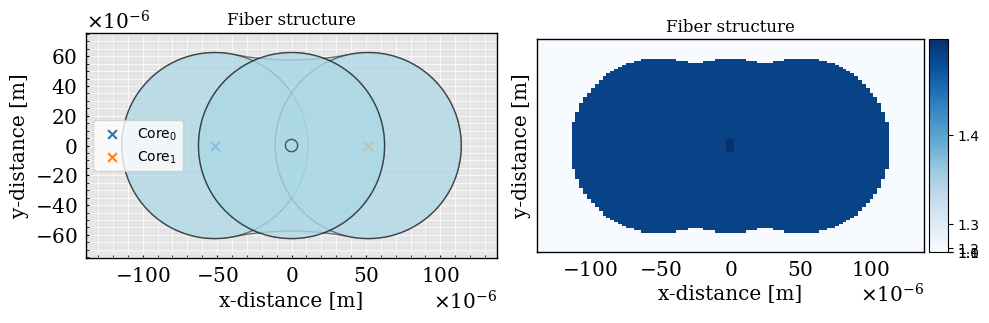

In [131]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment, Profile, StructureType
from SuPyMode.workflow import AlphaProfile
from PyOptik import MaterialBank

fused_structure = Profile()
clad_refractive_index = MaterialBank.fused_silica.compute_refractive_index(wavelength)  # Refractive
fibers = [fiber_loader.load_fiber('SMF28', clad_refractive_index=clad_refractive_index) for _ in range(2)]

fused_structure.add_structure(
    structure_type=StructureType.LINEAR,
    number_of_fibers=2,
    fusion_degree=0.3,
    fiber_radius=62.5e-6
)
fused_structure.refractive_index = clad_refractive_index
# boundaries = [
#   Boundaries(right=BoundaryValue.ZERO, bottom=BoundaryValue.ZERO),
#   Boundaries(right=BoundaryValue.ZERO, bottom=BoundaryValue.ZERO)
# ]
boundaries = [Boundaries()]
workflow = Workflow(
    fiber_list=fibers,
    clad_structure=fused_structure,
    wavelength=1.55e-6,
    resolution=100,
    x_bounds=DomainAlignment.CENTERING, # Mesh x-boundary structure.
    y_bounds=DomainAlignment.CENTERING, # Mesh y-boundary structure.
    boundaries=boundaries,
    n_sorted_mode=6
)

workflow.initialize_geometry(plot=True)  # Initialize the geometry and plot it

In [ ]:
workflow.run_solver()  # Run the solver to compute the modes
workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

In [127]:
profile = AlphaProfile()

profile.add_taper_segment(
    alpha=0,
    initial_heating_length=0.2e-6,
    stretching_length=1e-6,
)

profile.initialize()

propagation = workflow.superset.propagate(
    profile=profile,
    initial_amplitude=[0, 0, 1, 0, 0, 0],
    add_coupling = True,
    max_step = workflow.superset.wavelength / 400
)

In [104]:
import numpy as np
np.size(propagation.distance)

262

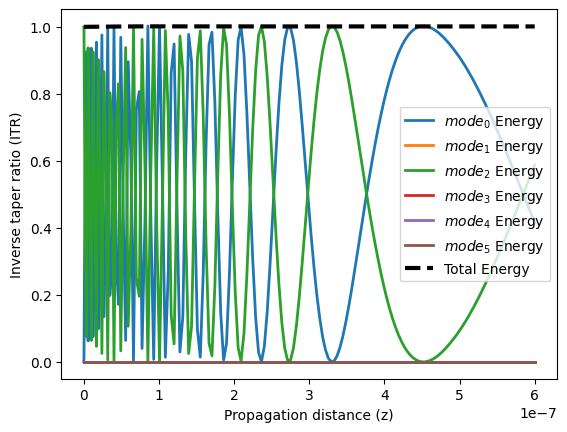

In [129]:
propagation.plot(sub_sampling = 1, show_energy = True, show_amplitudes = False)

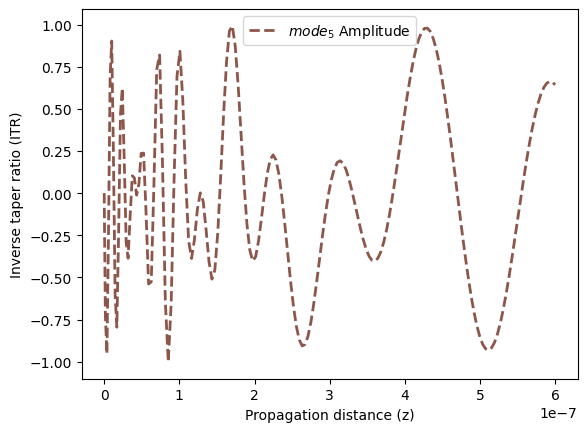

In [130]:
import matplotlib.pyplot as plt
sub_sampling = 1
fig, ax = plt.subplots()
ax.set(
    xlabel='Propagation distance (z)',
    ylabel='Inverse taper ratio (ITR)'
)

x_values = propagation.distance[::sub_sampling]

y_amplitude = propagation.amplitudes[0, ::sub_sampling].real
ax.plot(x_values, y_amplitude, label=f'{mode.stylized_label} Amplitude', linewidth=2.0, linestyle='--', color=color)
ax.legend()
# plt.xlim(0, 0.0005)

## Importing the package

In [ ]:
import SuPyMode
print(SuPyMode.__version__)

2.1.5


In [ ]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment, Profile, StructureType

from PyOptik import MaterialBank

In [ ]:
wavelength = 1550e-9

# %%
# Generating the fiber structure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the cladding and fiber structure to model the problem
clad_structure = Profile()

clad_structure.add_structure(
    structure_type=StructureType.CIRCULAR,
    number_of_fibers=4,
    fusion_degree=0.4,
    fiber_radius=62.5e-6,
    # compute_fusing=True
)

clad_structure.refractive_index = MaterialBank.fused_silica.compute_refractive_index(wavelength)  # Refractive index of silica at the specified wavelength


fiber_list = [
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[0]),
    fiber_loader.load_fiber('DCF1300S_26', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[1]),
    fiber_loader.load_fiber('DCF1300S_42', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[2]),
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[3]),
]

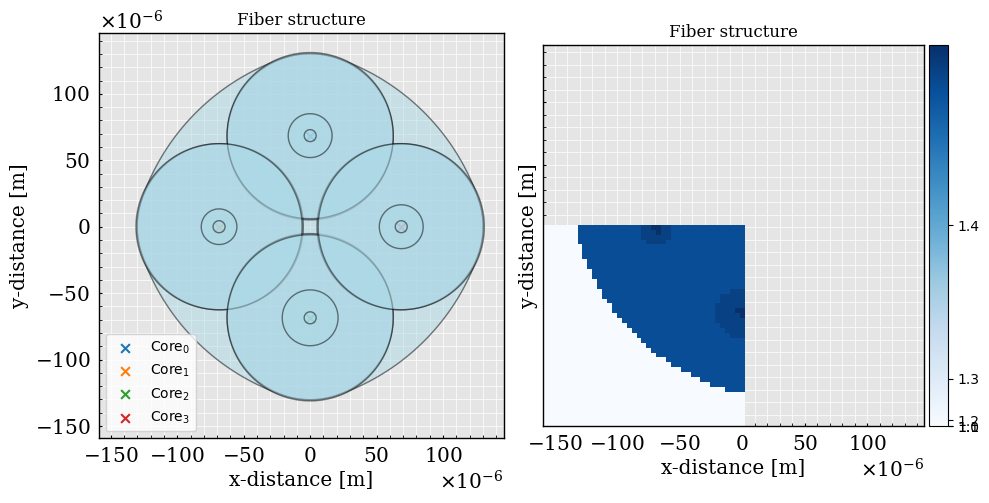

In [ ]:
boundaries = [
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.SYMMETRIC),
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.ANTI_SYMMETRIC),
]

workflow = Workflow(
    fiber_list=fiber_list,          # List of fiber to be added in the mesh, the order matters.
    clad_structure=clad_structure,  # Cladding structure, if None provided then no cladding is set.
    wavelength=wavelength,          # Wavelength used for the mode computation.
    resolution=80,                  # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
    x_bounds=DomainAlignment.LEFT,  # Mesh x-boundary structure.
    y_bounds=DomainAlignment.BOTTOM,# Mesh y-boundary structure.
    boundaries=boundaries,          # Set of symmetries to be evaluated, each symmetry add a round of simulation
    n_sorted_mode=3,                # Total computed and sorted mode.
    n_added_mode=5,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
    plot_geometry=True,             # Plot the geometry mesh before computation.
    debug_mode=0,                   # Print the iteration step for the solver plus some other important steps.
    auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
    itr_final=0.1,                  # Final value of inverse taper ratio to simulate
    index_scrambling=1e-4           # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

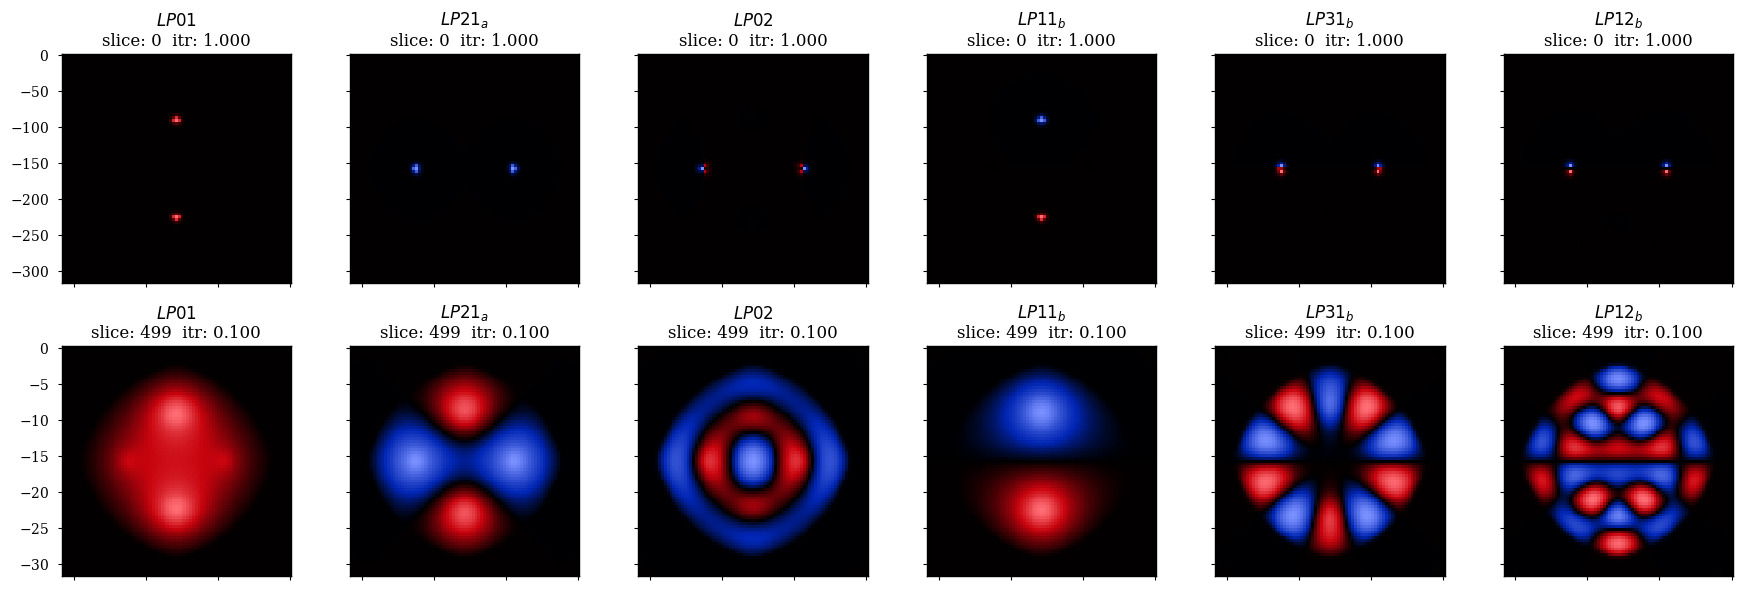

In [ ]:
_ = workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

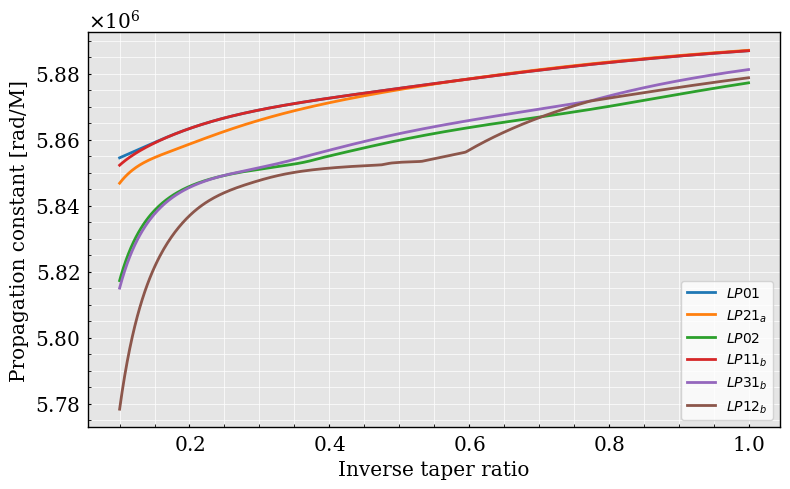

In [ ]:
_ = workflow.superset.plot(plot_type='beta')

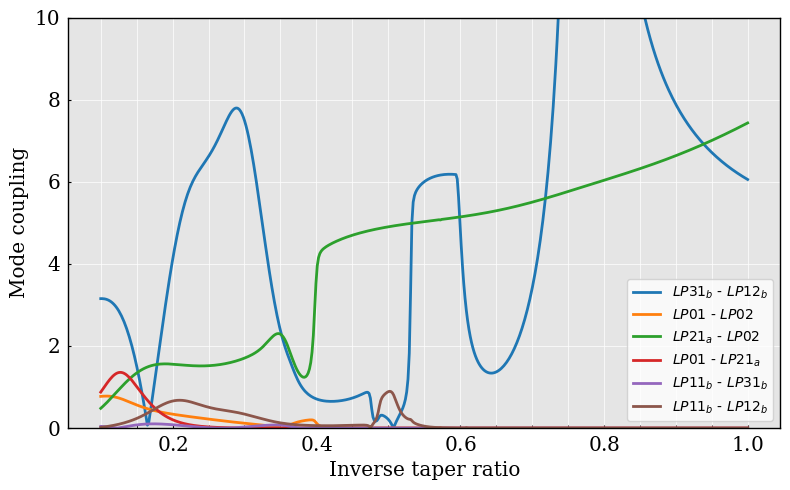

In [ ]:
_ = workflow.superset.plot(plot_type='normalized_coupling')

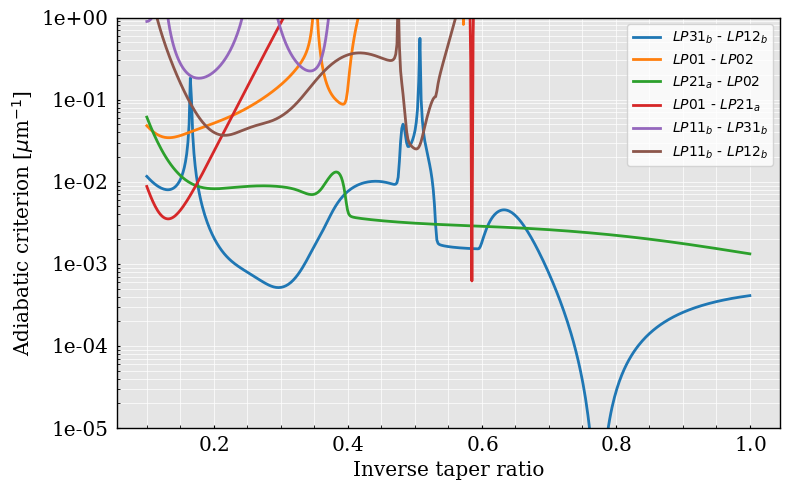

In [ ]:
_ = workflow.superset.plot(plot_type='adiabatic')